## Siamese Network on Audio Data
Meta-learning model is used to compensate for lack of data
### Import all necessary packages

In [1]:
import sys
#sys.path.append('/home/adrikamukherjee/venv/lib/python3.6/site-packages')

In [2]:
import glob
import IPython
from random import randint

#data processing
import librosa
import numpy as np

#modelling
from sklearn.model_selection import train_test_split

from keras import backend as K
from keras.layers import Activation
from keras.layers import Input, Lambda, Dense, Dropout, Flatten
from keras.models import Model
from keras.optimizers import RMSprop
import os

### Librosa is used to extract mfcc features from Audio Files
### Calculate max Shape(audio file having number of frames) from the audio files

In [8]:
list_dir=["C:/Users/Tilak Chan/OneDrive/Desktop/Tilak/BagOfLies/wavfiles"]
max=0
for dir in list_dir:
    for file in glob.glob(os.path.join(dir, '*.wav')):
        audio, sr = librosa.load(file)
        shape=0
        #extract the audio embeddings using MFCC
        mfcc = librosa.feature.mfcc(y=audio, sr=sr) 
        no= int(mfcc.shape[1])
        if(no > max):
            max=no

print(max)        

1817


### "audio2vector" function is used to extract mfcc features and pad Audio files with max pad length obtained in previous step

In [19]:
def audio2vector(file_path, max_pad_len=3508):
    
    #read the audio file
    audio, sr = librosa.load(file_path, mono=True)
    
    #extract the audio embeddings using MFCC
    mfcc = librosa.feature.mfcc(y=audio, sr=sr) 
    shape=mfcc.shape[1]
    #as the audio embeddings length varies for different audio, we keep the maximum length as 400
    #pad them with zeros
    pad_width = max_pad_len - mfcc.shape[1]
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    return mfcc

### "get_training_data" function is used to generate training data such that Two deceptive audio vectors are labeled as 1; one deceptive and one truthful vector are labeled as 0.

In [20]:
def get_training_data():
    
    pairs = []
    labels = []
    
    Deceptive = glob.glob('C:/Users/Tilak Chan/OneDrive/Desktop/Tilak/BagOfLies/Audio_features/Deceptive/*.wav')
    Truthful = glob.glob('C:/Users/Tilak Chan/OneDrive/Desktop/Tilak/BagOfLies/Audio_features/Truthful/*.wav')
    
    
    #np.random.shuffle(Sub_Deceptive).astype(np.int64)
    #np.random.shuffle(Truthful).astype(np.int64)
    
    for i in range(len(Truthful)):
        #imposite pair
        if (i % 2) == 0:
            pairs.append([audio2vector(Deceptive[randint(0,3)]),audio2vector(Truthful[i])])
            labels.append(0)
            
        #genuine pair
        else:
            pairs.append([audio2vector(Deceptive[randint(0,3)]),audio2vector(Truthful[i])])
            labels.append(1)
            
            
    return np.array(pairs), np.array(labels)

### Calculate data and Ground truths and store in X and Y

In [21]:
X, Y = get_training_data()

In [23]:
print(X)
print("Break")
print(Y)

[[[[-7.3617212e+02 -7.3617212e+02 -7.3617212e+02 ...  0.0000000e+00
     0.0000000e+00  0.0000000e+00]
   [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
     0.0000000e+00  0.0000000e+00]
   [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
     0.0000000e+00  0.0000000e+00]
   ...
   [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
     0.0000000e+00  0.0000000e+00]
   [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
     0.0000000e+00  0.0000000e+00]
   [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
     0.0000000e+00  0.0000000e+00]]

  [[-7.5600391e+02 -7.5600391e+02 -7.5600391e+02 ...  0.0000000e+00
     0.0000000e+00  0.0000000e+00]
   [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
     0.0000000e+00  0.0000000e+00]
   [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
     0.0000000e+00  0.0000000e+00]
   ...
   [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0

##### Convert Ground truth type to float 32

In [24]:
import pandas as pd
Y=pd.Series(Y).astype('float32')
Y=Y.to_numpy()

### Split Train and Test Data

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

### Base Model with two simple dense layer for feature extraction is built.

In [26]:
def build_base_network(input_shape):
    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(150, activation='relu')(x)
    #x = Dropout(0.1)(x)
    x = Dense(150, activation='relu')(x)
    #x = Dropout(0.1)(x)
    return Model(input, x)

### Audio pair is fed into the base network, which will return the features.

In [27]:
input_dim = X_train.shape[2:]

audio_a = Input(shape=input_dim)
audio_b = Input(shape=input_dim)

In [28]:
base_network = build_base_network(input_dim)

feat_vecs_a = base_network(audio_a)
feat_vecs_b = base_network(audio_b)

### 'feat_vecs_a' and 'feat_vecs_b' are the feature vectors of audio pair;these feature vectors is fed into  the energy function to compute a distance between them,  Euclidean distance is used as energy function:

In [29]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [30]:
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([feat_vecs_a, feat_vecs_b])

### epoch length is set to 15 and  RMS prop is used for optimization.

In [31]:
epochs = 15
rms = RMSprop()

In [32]:
model = Model(inputs=[audio_a, audio_b], outputs=distance)

### distance based Contrastive loss is defined

In [33]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

### Model is compiled

In [34]:
model.compile(loss=contrastive_loss, optimizer=rms)

### Train and Test data is seperated

"audio_1" and "audio_2" is used for training the model.
"audio_3" and "audio_4" is used for training the model.
The input of final model requires two videos, one from each pair is fed into the model.

In [35]:
audio_1 = X_train[:, 0]
audio_2 = X_train[:, 1]
audio_3 = X_test[:, 0]
audio_4 = X_test[:, 1]

In [37]:
history=model.fit([audio_1, audio_2], y_train, validation_data=[[audio_3, audio_4], y_test],batch_size=128, verbose=2, epochs=epochs)


Epoch 1/15
2/2 - 2s - loss: 34403.2578 - val_loss: 772343.4375 - 2s/epoch - 1s/step
Epoch 2/15
2/2 - 0s - loss: 723876.3750 - val_loss: 623605.5625 - 392ms/epoch - 196ms/step
Epoch 3/15
2/2 - 0s - loss: 678520.3125 - val_loss: 185676.2188 - 363ms/epoch - 182ms/step
Epoch 4/15
2/2 - 0s - loss: 228664.9531 - val_loss: 161172.4375 - 355ms/epoch - 178ms/step
Epoch 5/15
2/2 - 0s - loss: 227579.8125 - val_loss: 45108.1445 - 361ms/epoch - 180ms/step
Epoch 6/15
2/2 - 0s - loss: 81445.4609 - val_loss: 26646.6133 - 364ms/epoch - 182ms/step
Epoch 7/15
2/2 - 0s - loss: 56617.2930 - val_loss: 18738.6367 - 361ms/epoch - 181ms/step
Epoch 8/15
2/2 - 0s - loss: 45005.7930 - val_loss: 78372.1562 - 358ms/epoch - 179ms/step
Epoch 9/15
2/2 - 0s - loss: 107520.0859 - val_loss: 38813.0977 - 373ms/epoch - 187ms/step
Epoch 10/15
2/2 - 0s - loss: 47546.2734 - val_loss: 14911.7441 - 356ms/epoch - 178ms/step
Epoch 11/15
2/2 - 0s - loss: 31630.3691 - val_loss: 25352.8066 - 367ms/epoch - 184ms/step
Epoch 12/15
2/2 

### Plot Meta Model loss

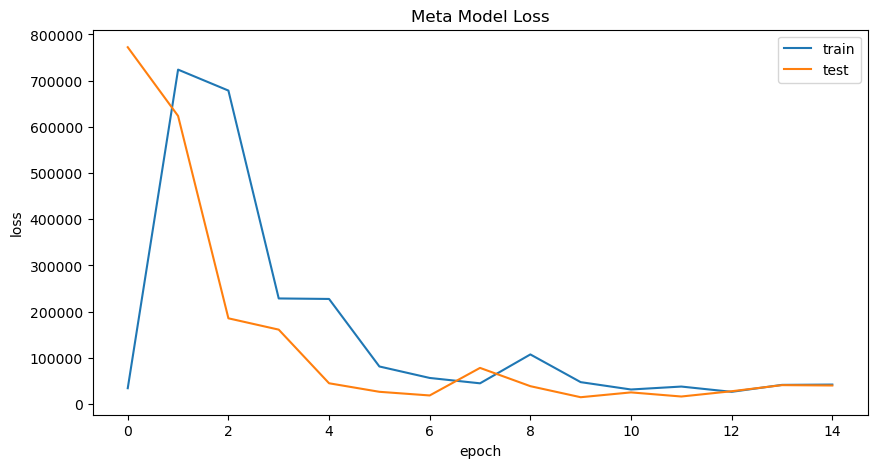

In [38]:
import matplotlib.pyplot as plt
def plot_acc_loss(history):

    fig = plt.figure(figsize=(10,5))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Meta Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()


plot_acc_loss(history)

### Predict on Test Data

In [39]:
y_pred = model.predict([audio_3, audio_4])
y_pred

2/2 [==============================] - 0s 10ms/step


array([[234.72032 ],
       [168.49829 ],
       [ 62.627544],
       [355.18173 ],
       [220.09258 ],
       [509.6862  ],
       [204.38425 ],
       [196.06566 ],
       [260.0767  ],
       [236.80281 ],
       [750.8384  ],
       [313.84772 ],
       [126.27959 ],
       [ 99.06149 ],
       [ 97.271576],
       [124.495186],
       [161.0155  ],
       [773.74677 ],
       [ 80.38462 ],
       [ 62.398537],
       [355.45508 ],
       [215.97232 ],
       [ 94.91582 ],
       [214.58818 ],
       [266.87625 ],
       [123.03421 ],
       [446.64914 ],
       [190.54066 ],
       [601.01215 ],
       [164.8308  ],
       [121.17724 ],
       [322.83603 ],
       [369.4964  ]], dtype=float32)

### Display Confusion Matrix

In [40]:
import sklearn
from sklearn.preprocessing import label_binarize
y_true = label_binarize(y_test, classes = [0, 1]) # y_test --> You get it from train_test_split

y_pred = model.predict([audio_3, audio_4])
y_pred_det = label_binarize(pd.Series(y_pred[:, 0]).apply(lambda y: 0 if y<80 else 1), classes = [0, 1])

conf = sklearn.metrics.confusion_matrix
conf = sklearn.metrics.confusion_matrix
conf(y_true, y_pred_det)

2/2 [==============================] - 0s 8ms/step


array([[ 1, 19],
       [ 1, 12]], dtype=int64)

### Calculate Precision and Recall and other Metrics

In [41]:
conf_res = conf(y_true, y_pred_det)
print("Precision in predicting two deceptive videos: ", conf_res[1][1]/(conf_res[1][1]+conf_res[0][1]))
print("Recall in in predicting two deceptive videos: ", conf_res[1][1]/(conf_res[1][1]+conf_res[1][0]))

Precision in predicting two deceptive videos:  0.3870967741935484
Recall in in predicting two deceptive videos:  0.9230769230769231


In [42]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix,cohen_kappa_score,roc_auc_score, accuracy_score


# Print f1, precision, and recall scores
prec = precision_score(y_true, y_pred_det , average="macro")
rec = recall_score(y_true, y_pred_det , average="macro")
fsc= f1_score(y_true, y_pred_det , average="macro")
# kappa
kappa = cohen_kappa_score(y_true, y_pred_det)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_true, y_pred_det)
print('ROC AUC: %f' % auc)
accu = accuracy_score(y_true, y_pred_det)
print('Precision: %f' % prec)
print('Recall: %f' % rec)
print('Accuracy: %f' % accu)
print('fsc: %f' % fsc)

Cohens kappa: -0.021672
ROC AUC: 0.486538
Precision: 0.443548
Recall: 0.486538
Accuracy: 0.393939
fsc: 0.318182


### Plot ROC Curve

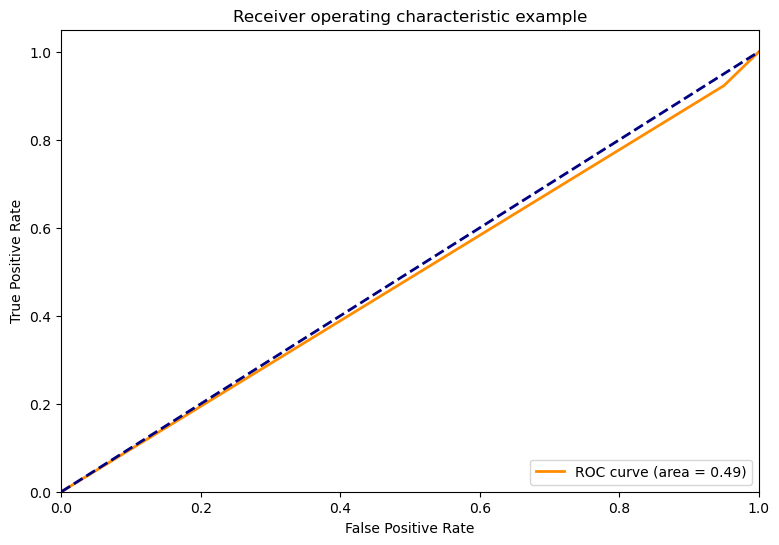

In [43]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
i=0
fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_det[:, i])
roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(9, 6))
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()